In [1]:
%matplotlib notebook
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt

from scipy.io import loadmat
import matplotlib.colors as color
from matplotlib.animation import FuncAnimation
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler

In [15]:
Kol=loadmat('Kol_Label.mat')
datapts = np.load("/Users/senlin/Downloads/Kolmogorov_Flow/allVAElatent.npy") 
state=Kol['state'].squeeze()
w=Kol['w'] #This data is separated every 5 time units
[M,N1,N2]=w.shape
w=w.reshape(M,-1)

<IPython.core.display.Javascript object>


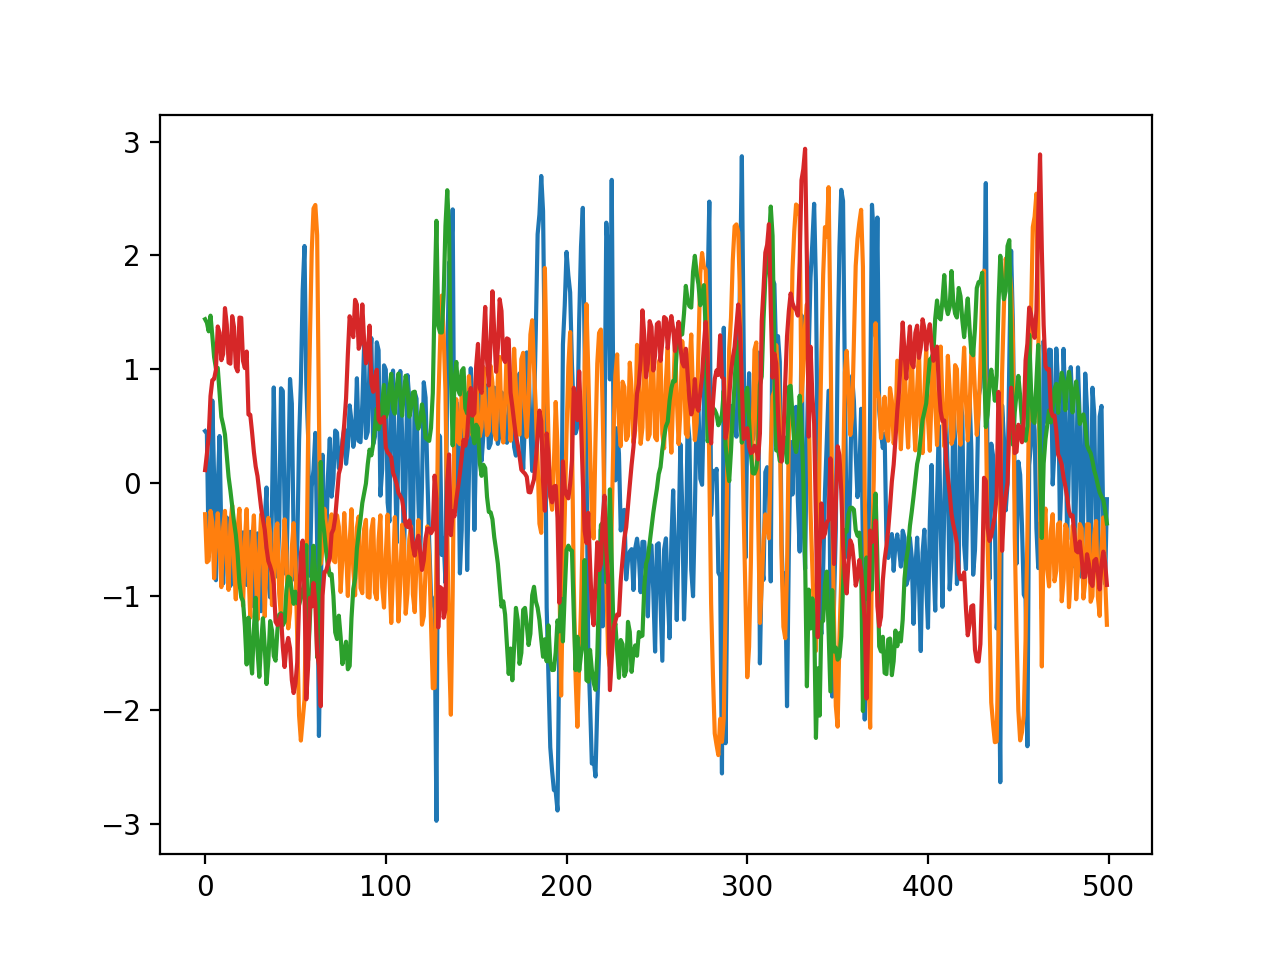

In [16]:
plt.figure()
plt.plot(datapts[:,:500].T)

In [17]:
#### we select first 5000 data for LSTM experiment. 0.5 for training-test split
training_set = np.diff(datapts[:,:5000]).T
sc = StandardScaler()
training_data = sc.fit_transform(training_set)

teststate=state
Tw = w[1:5000,:]
Tstate = teststate[1:5000]

We use sliding window to split the sequence, window size are chosen as 5,10,15
We will train 3 models that they are trained by predicting next window

In [18]:
def sliding_windows(data, seq_length):
### data preprocessing. Feature standardization -> rolling window with size "seq_length" -> train-test split

        x = []
        y = []

        for i in range(len(data)-2*seq_length):
            _x = data[i:(i+seq_length),:]
            _y = data[i+seq_length:i+2*seq_length,:]
            x.append(_x)
            y.append(_y)

        return np.array(x),np.array(y)
    
def model(data,seq_length):       

    
    x, y = sliding_windows(training_data, seq_length)

    train_size = int(len(y) * 0.5)
    test_size = len(y) - train_size

    dataX = Variable(torch.Tensor(np.array(x))).cuda()
    dataY = Variable(torch.Tensor(np.array(y))).cuda()

    trainX = Variable(torch.Tensor(np.array(x[0:train_size,:]))).cuda()
    trainY = Variable(torch.Tensor(np.array(y[0:train_size,:]))).cuda()

    testX = Variable(torch.Tensor(np.array(x[train_size:len(x),:]))).cuda()
    testY = Variable(torch.Tensor(np.array(y[train_size:len(y),:]))).cuda()
    #### use least absolute deviation for regression
    num_epochs = 2000
    learning_rate = 0.002/5*seq_length

    input_size = 4
    hidden_size = 4
    num_layers = 1

    num_classes = 4

    lstm = nn.LSTM(input_size, hidden_size, num_layers).cuda()

    criterion = torch.nn.L1Loss()    # L1 loss for regression
    optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
    #optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

    # Train the model
    for epoch in range(num_epochs):
        outputs = lstm(trainX)[0]
        optimizer.zero_grad()

        # obtain the loss function
        loss = criterion(outputs, trainY)

        loss.backward()

        optimizer.step()
        if epoch % 100 == 0:
            print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

    return lstm

In [ ]:
# train 3 models with different forecasting window size
trained_lstm = dict()
seq_length = [5,10,15]
for i,seq_len in enumerate(seq_length):
    trained_lstm[i] = model(training_set,seq_len)

In [31]:
lstm = nn.LSTM(input_size, hidden_size, num_layers)
lstm.eval()
checkpoint = torch.load('m3.pth',map_location=torch.device('cpu'))
lstm.load_state_dict(checkpoint)
lstm.eval()


LSTM(4, 4)

We define anomaly score by using the maximum prediction error, eg. we predict value in the next 5 timestep, and use the maximum absolute error as the anomaly score. 

<IPython.core.display.Javascript object>


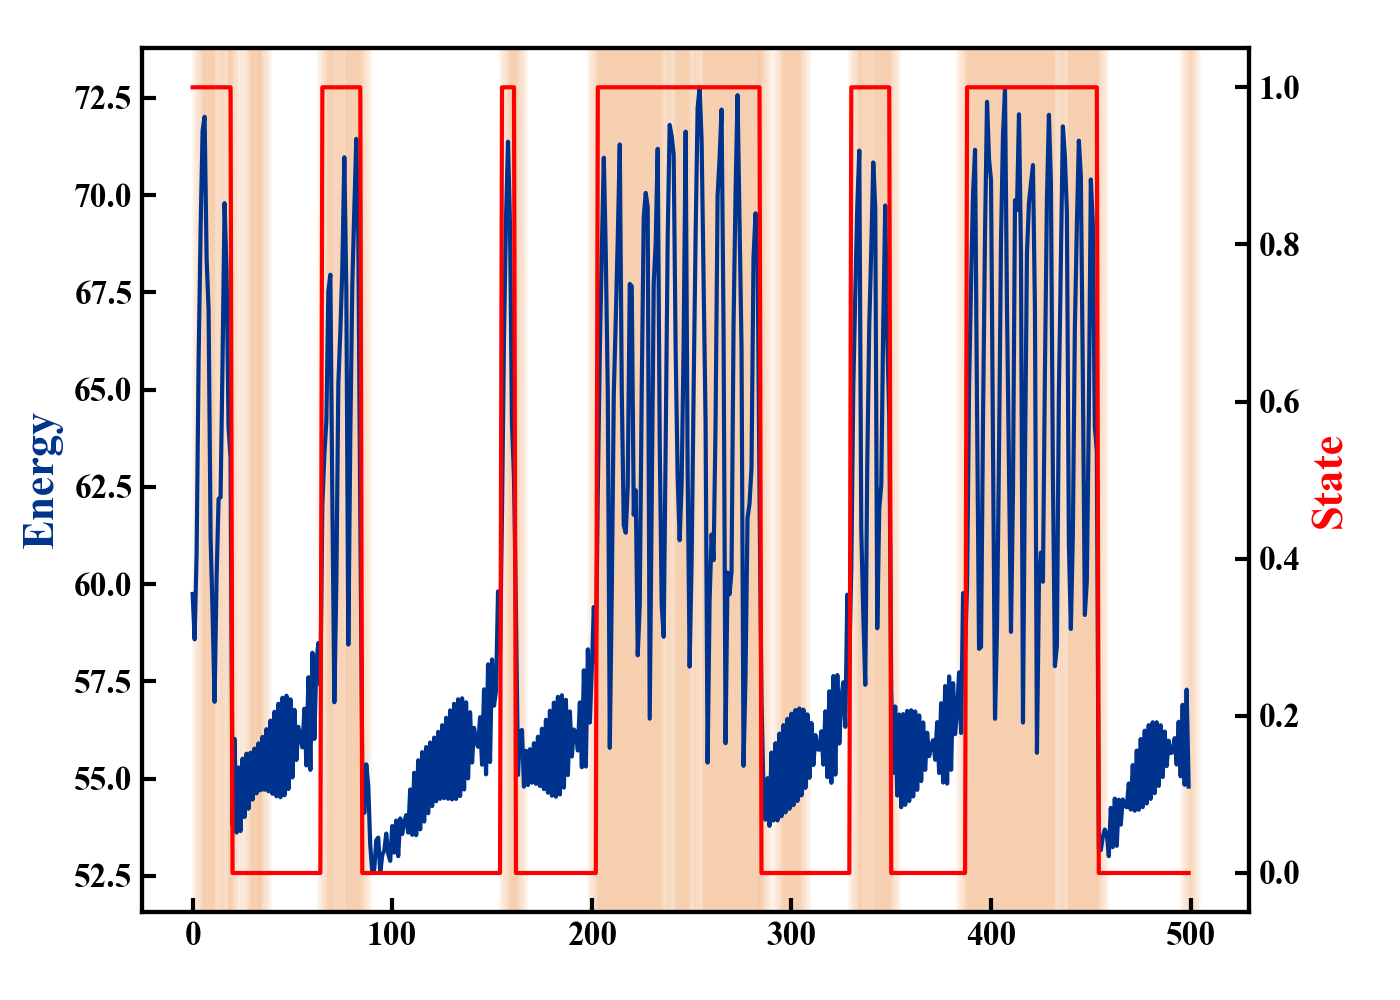

<IPython.core.display.Javascript object>


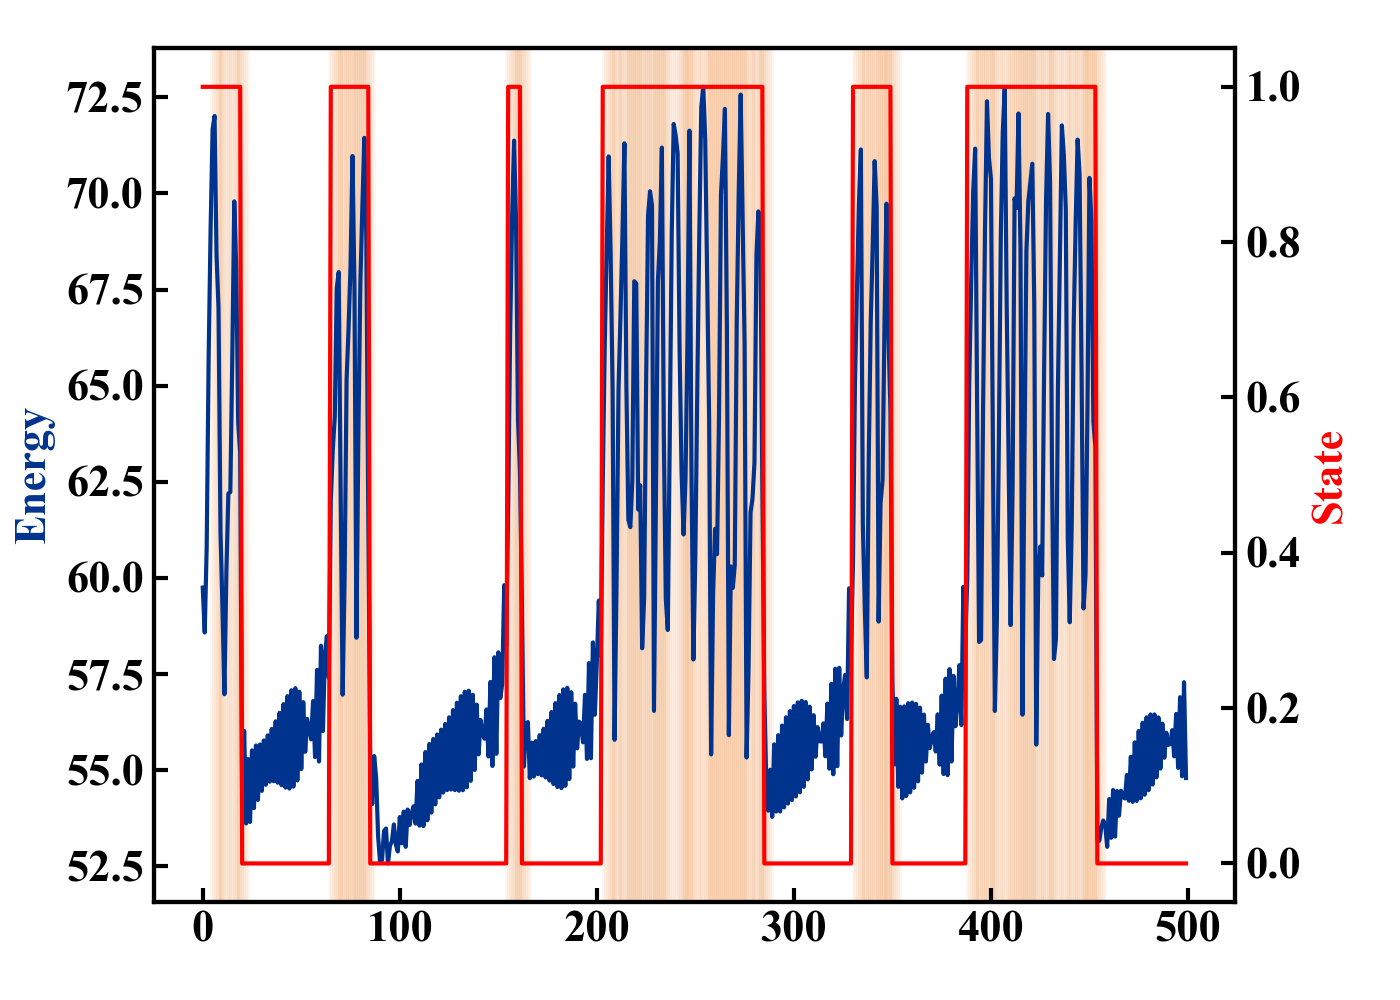

<IPython.core.display.Javascript object>


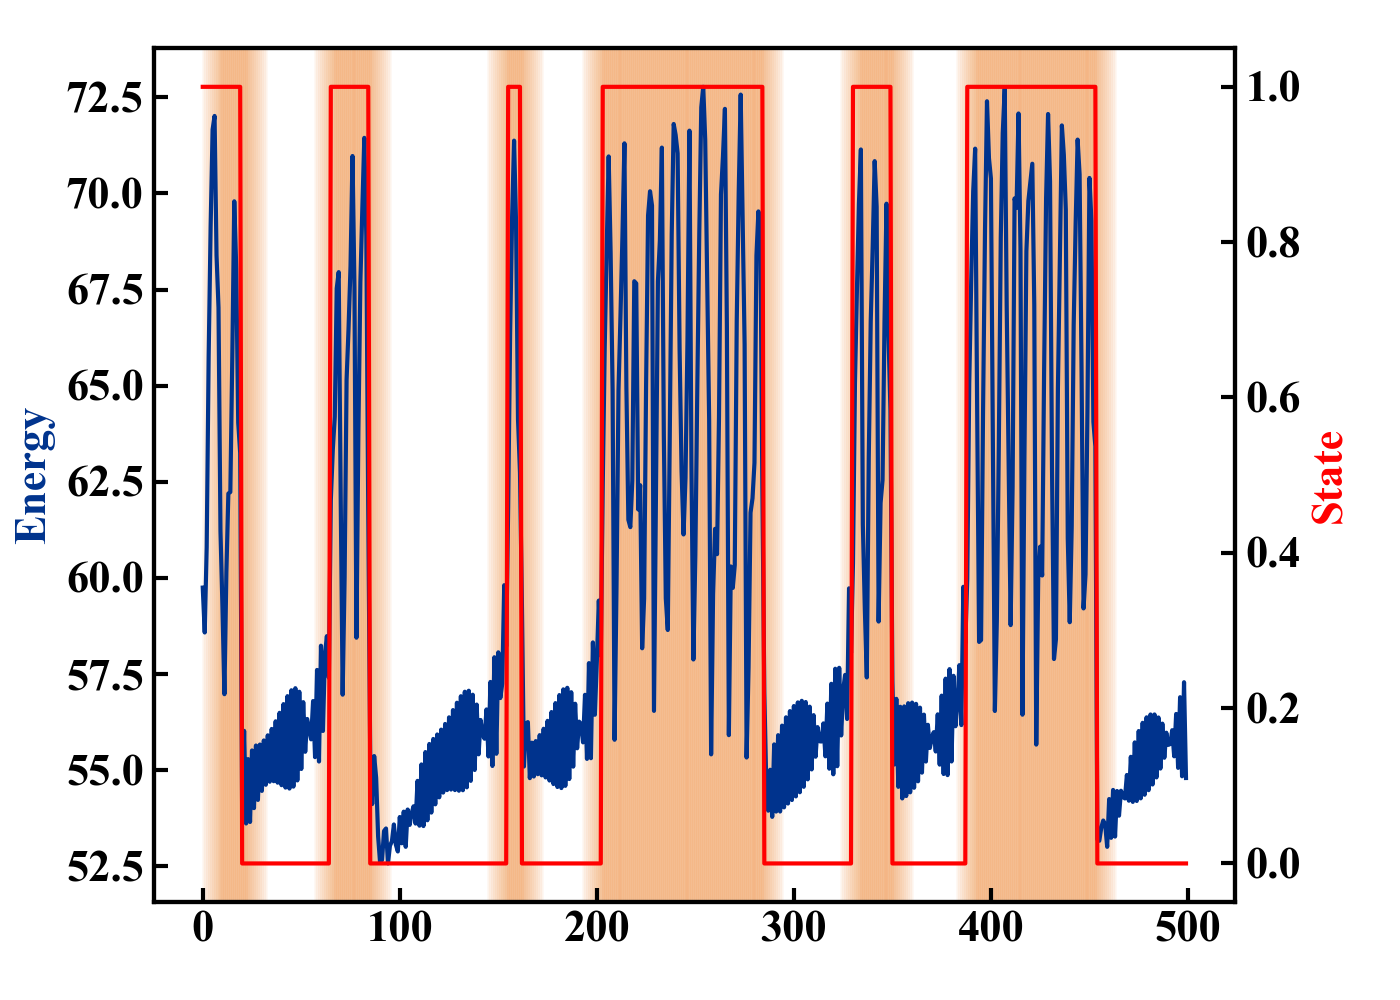

<IPython.core.display.Javascript object>


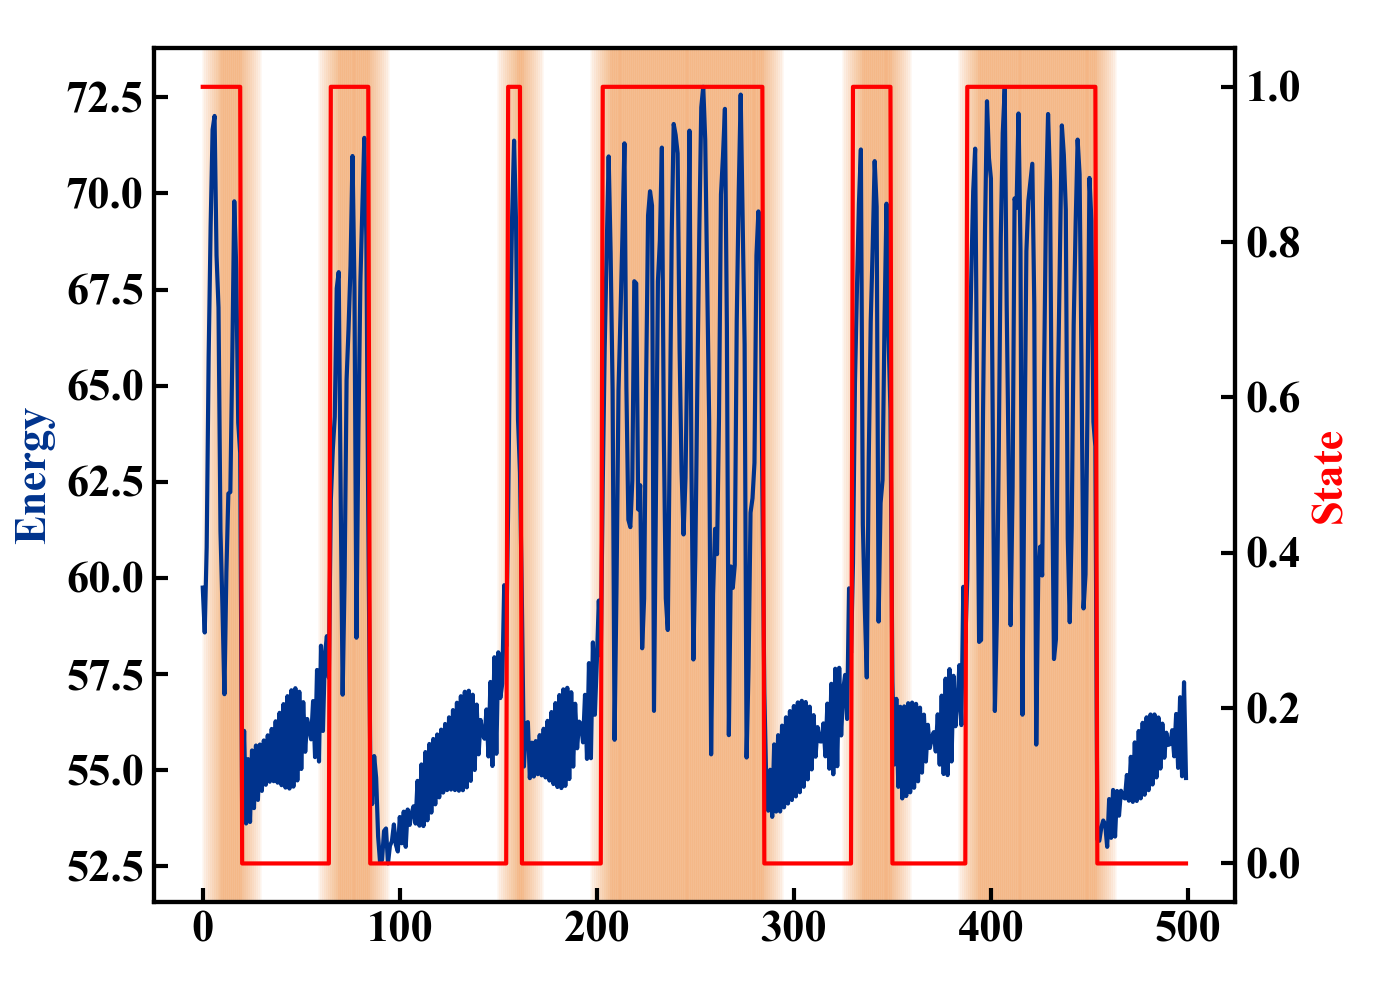

<IPython.core.display.Javascript object>


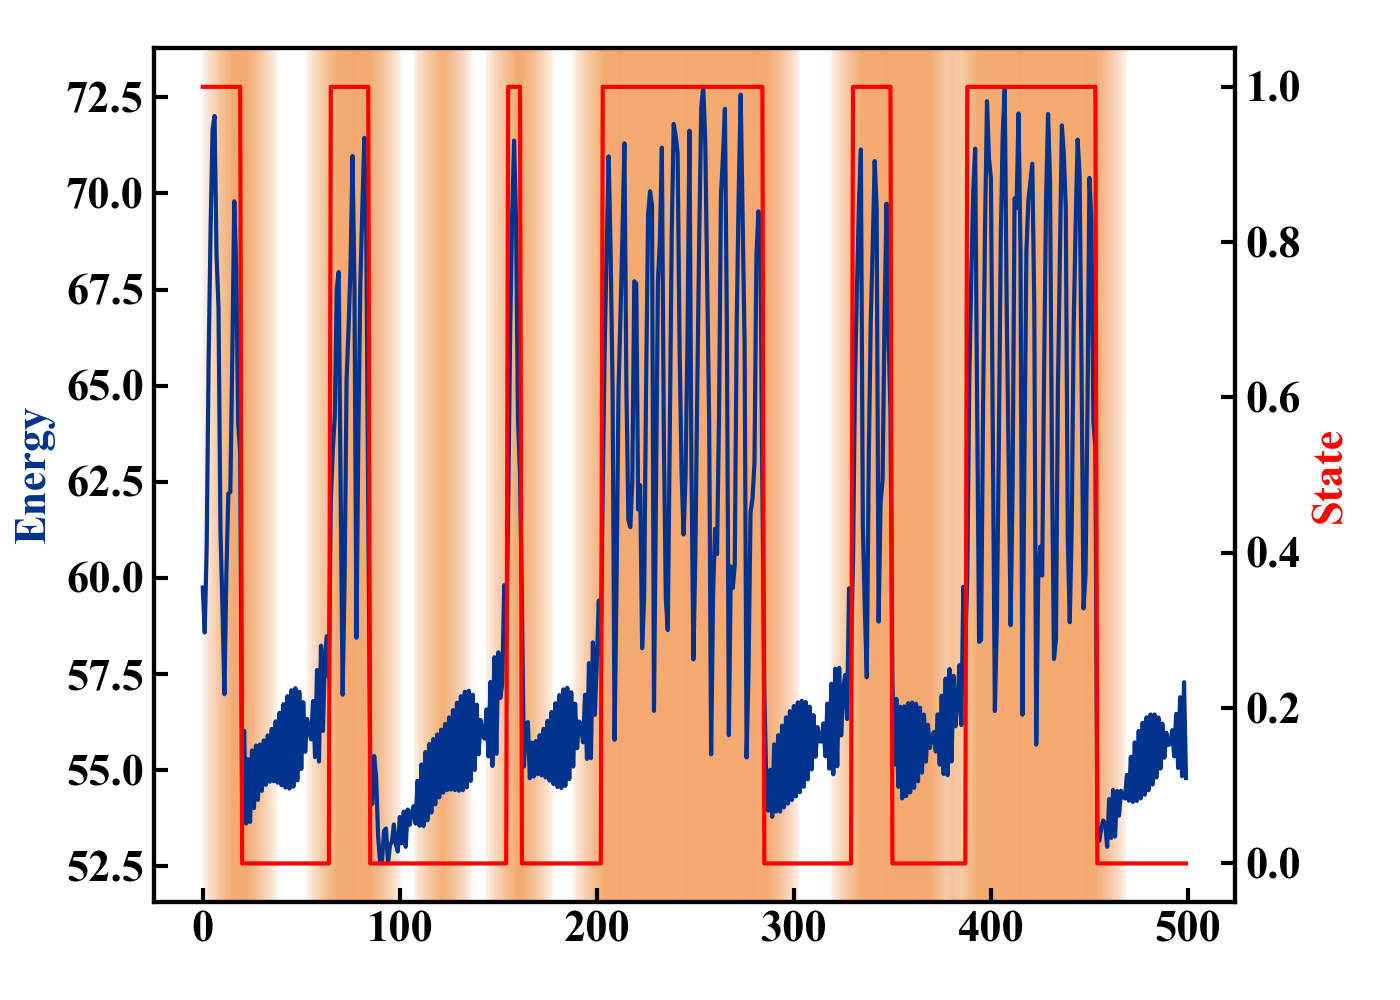

<IPython.core.display.Javascript object>


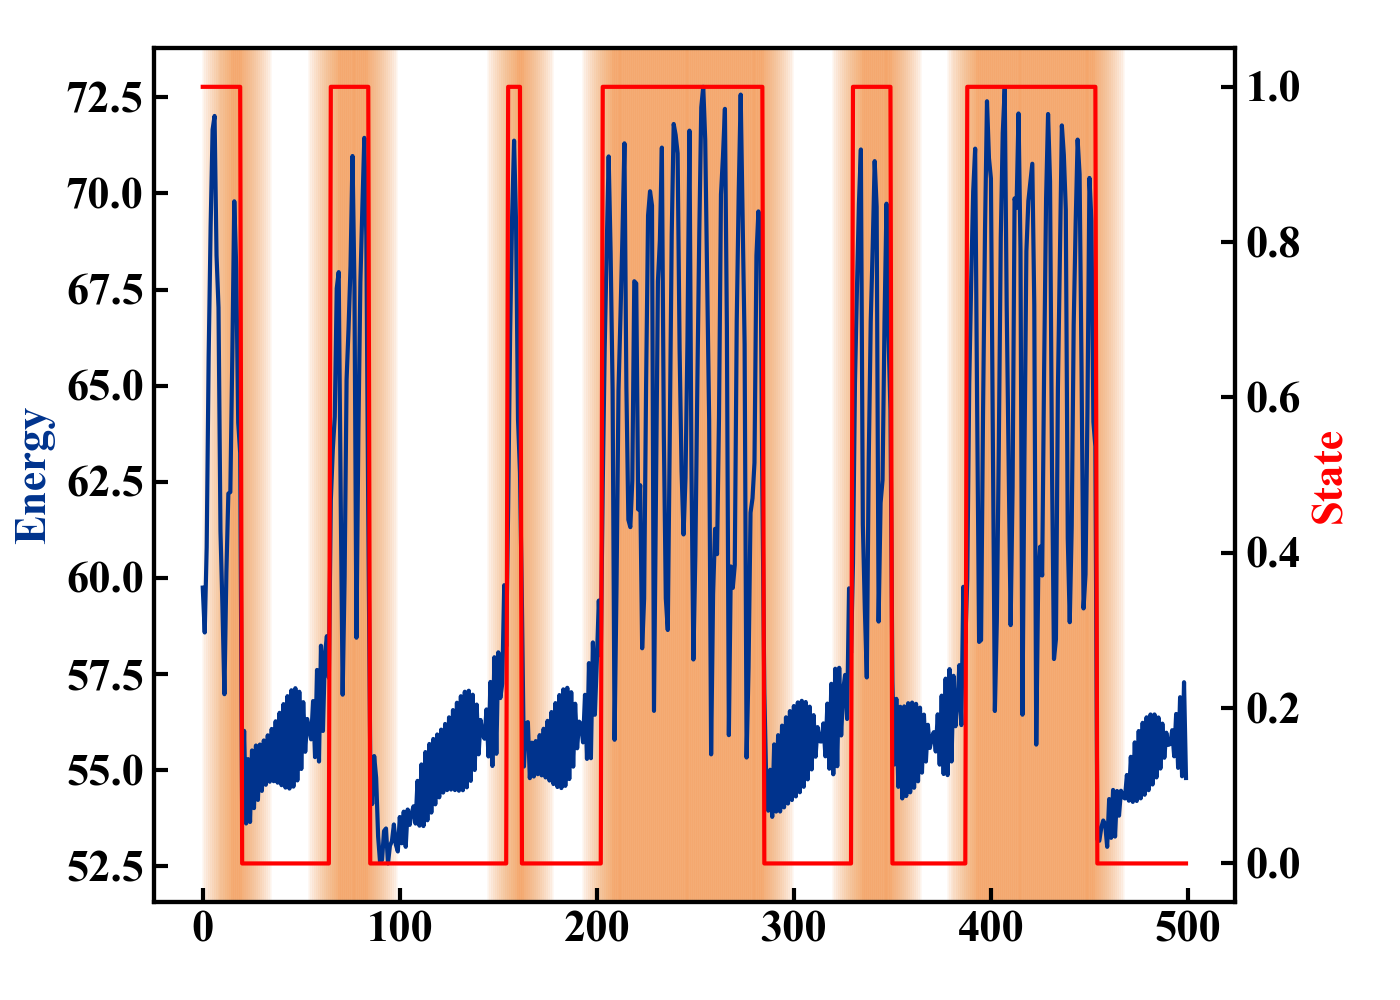

In [90]:
### we visualize anomaly detection reuslts with different forecasting window and anomaly score threshold 
### we paint on the window where anomaly is detected
### the shalow area represents the beginning or end of a regieme change

threshold = [0.2,0.3]

for i in range(3):
    x, y = sliding_windows(training_data, seq_length[i])
    dataX = Variable(torch.Tensor(np.array(x)))
    dataY = Variable(torch.Tensor(np.array(y)))
    
    lstm = nn.LSTM(input_size, hidden_size, num_layers)
    lstm.eval()
    checkpoint = torch.load("".join(['m',str(i+1),'.pth']),map_location=torch.device('cpu'))
    lstm.load_state_dict(checkpoint)
    lstm.eval()
    train_predict = lstm(dataX)[0]
    train_predict = lstm(dataX)[0]
    data_predict = train_predict.data.numpy()
    dataY_plot = dataY.data.numpy()

    #define anomaly score
    anomaly_score = np.linalg.norm(data_predict-dataY_plot,axis=2).max(axis=1)/10
    

    # Plotting
    for j in range(2):
        fig, ax = plt.subplots(figsize=(7, 5))
        Sanomaly = anomaly_score[4200 - seq_length[i]:4700 - seq_length[i]]
        anomaly = np.where(Sanomaly > threshold[j])[0]

        for k in range(len(anomaly)):
            paint = ax.axvspan(anomaly[k], anomaly[k] + seq_length[i], alpha=0.05, color='#F47D20')
        ax.plot(np.linalg.norm(w[4200:4700, :], axis=1), linewidth=1.5, color='#00338D')
        ax.set_ylabel('Energy', fontsize=16, color='#00338D')
        ax2 = ax.twinx()
        ax2.plot(teststate[4200:4700], 'r-', linewidth=1.5)

        ax2.set_ylabel('State', fontsize=16, color='red')
        #ax.set_title(" ".join(['Threshold = ', str(threshold[j]*10)]), fontsize=16)

        # Styling
        plt.style.use('default')
        plt.rcParams['axes.linewidth'] = 1.5
        plt.rcParams['font.family'] = 'Times New Roman'
        plt.rcParams['font.size'] = 16
        plt.rcParams['xtick.major.size'] = 5
        plt.rcParams['ytick.major.size'] = 5
        plt.rcParams['xtick.major.width'] = 1.5
        plt.rcParams['ytick.major.width'] = 1.5
        plt.rcParams['xtick.direction'] = 'in'
        plt.rcParams['ytick.direction'] = 'in'
        plt.tight_layout()

        plt.savefig("".join(['lstm',str(i+1),'thr',str(j+1),'.png']), dpi=300, bbox_inches='tight')

<IPython.core.display.Javascript object>


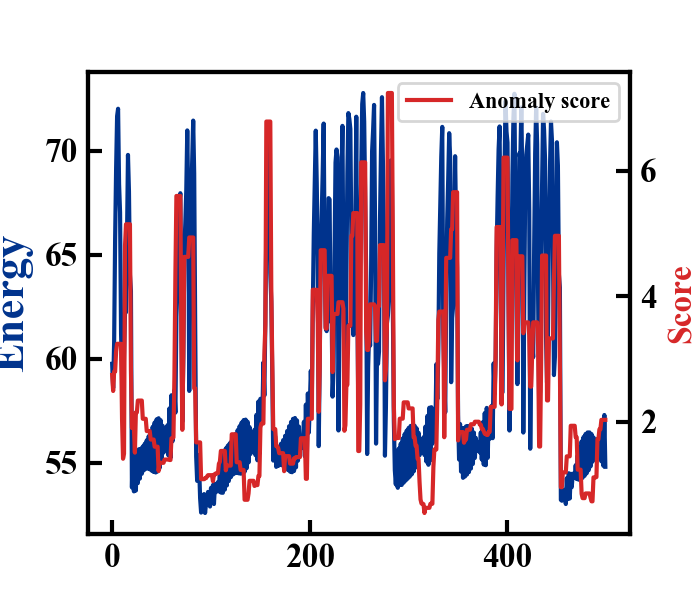

<IPython.core.display.Javascript object>


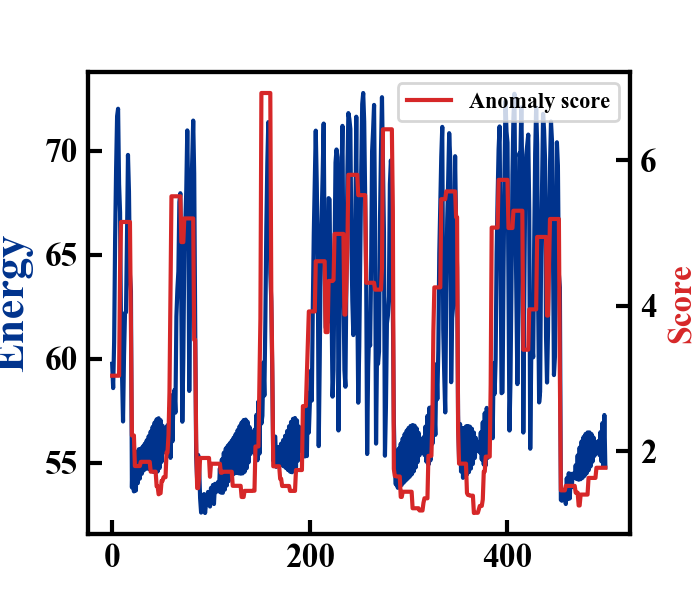

<IPython.core.display.Javascript object>


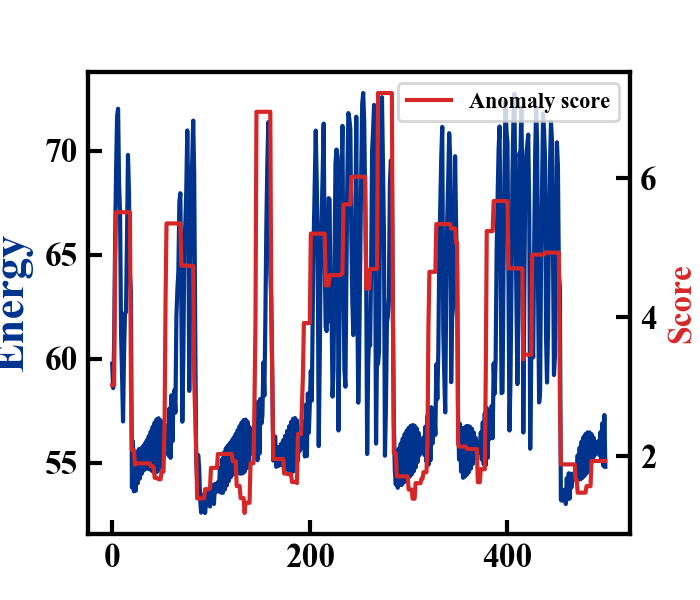

In [58]:
### we found the anomaly score has a similar pattern to the energy of the flow

for i in range(3):
    x, y = sliding_windows(training_data, seq_length[i])
    dataX = Variable(torch.Tensor(np.array(x)))
    dataY = Variable(torch.Tensor(np.array(y)))
    
    lstm = nn.LSTM(input_size, hidden_size, num_layers)
    lstm.eval()
    checkpoint = torch.load("".join(['m',str(i+1),'.pth']),map_location=torch.device('cpu'))
    lstm.load_state_dict(checkpoint)
    lstm.eval()
    train_predict = lstm(dataX)[0]
    train_predict = lstm(dataX)[0]
    data_predict = train_predict.data.numpy()
    dataY_plot = dataY.data.numpy()

    anomaly_score = np.linalg.norm(data_predict-dataY_plot,axis=2).max(axis=1)
    plt.rcParams['font.size'] = 8*3/2

    fig, ax = plt.subplots(figsize=(3.5,3))
    ax.plot(np.linalg.norm(w[4200:4700, :], axis=1), linewidth=1.5, color='#00338D')
    ax.set_ylabel('Energy', fontsize=16, color='#00338D')
    ax2 = ax.twinx()
    ax2.plot(anomaly_score[4200-seq_length[i]:4700-seq_length[i]],color='#d62728', label='Anomaly score')
    ax2.set_ylabel('Score', color='#d62728',fontsize=8*3/2)
    ax2.set_xlabel('Time', fontsize=8*3/2)
    #ax.set_title('Anomaly score', fontsize=8*3/2)
    #ax2.grid(True)
    #ax.set_ylim([0, 2])
    ax2.legend(loc='best', fontsize=8)
    plt.savefig("".join(['anomaly_score',str(i+1),'.png']), dpi=300, bbox_inches='tight')
    #ax.set_ylim([0, 2])
    #ax[i].legend(loc='best', fontsize=12)
    
#plt.savefig("".join(['anomaly_score',str(i+1),'.png']), dpi=300, bbox_inches='tight')